## Presidents and Income
### An intro to python
In this notebook we'll use historical data to look at the relationships between presidential parties and income growth.

The first step is to import the libraries we need for the analysis.

In [1]:
import numpy as np #a numerical python library for working with arrays
import pandas as pd # data science library for dataframes and data manipulation
import altair as alt # a graphing library
import os #operating system library to set the working directory

In [2]:
# setting the working directory locally. This is a step you need to change
# os.chdir("/Users/bi6fgjk/Documents/pers/py_study") 

# First Data Source: Income

Pandas has a read_csv function that can read files directly from Github. This is convenient since it saves people from needing to download the files in order to follow along. 

I made a csv of table F-1: https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-families.html and saved it to Github to make it available for download. 

All values are in 2019 dollars as provided by the Census.

Footnotes to the data are available here: https://www.census.gov/topics/income-poverty/income/guidance/cps-historic-footnotes.html

In [3]:
hist_df = pd.read_csv("https://raw.githubusercontent.com/natekratzer/hist_income_by_quintile/main/hist_income47.csv")
hist_df.tail(8) #checking the last 8 rows

,Year,20,40,60,80,95
67,1954,"16,759","29,479","39,907","54,676","86,645"
68,1953,"17,976","30,507","40,936","55,130","85,738"
69,1952 (7),"17,370","28,098","38,014","51,416","79,996"
70,1951,"16,826","27,432","36,289","49,548","77,652"
71,1950,"15,441","26,550","35,335","49,112","80,088"
72,1949 (6),"14,523","24,811","33,471","47,298","75,921"
73,1948,"15,385","25,295","33,773","47,114","76,722"
74,1947 (5),"15,903","25,662","34,799","49,377","81,043"


In [4]:
# suppose I want to inspect the data more
# an easy way is to write a quick .csv file and then open it still in Jupyter Lab
hist_df.to_csv("explore_my_data.csv")

The year column has footnotes in it that are marked off with parentheses.
So I googled 'Regular Expression to remove everything in parentheses'. 

In [5]:
hist_df['Year'] = hist_df['Year'].str.replace(r"\(.*\)", "")
hist_df.head()

/tmp/ipykernel_7682/2993922613.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  hist_df['Year'] = hist_df['Year'].str.replace(r"\(.*\)", "")


,Year,20,40,60,80,95
0,2019,"40,000","69,000","105,038","164,930","304,153"
1,2018,"36,514","64,165","98,085","152,837","284,299"
2,2017,"35,252","62,960","97,523","153,979","284,244"
3,2017,"34,992","62,610","96,324","151,622","272,736"
4,2016,"34,518","61,732","95,637","148,691","267,602"


Here I'm going to define a function for the first time. This is a function to replace all commas with nothing at all (i.e. to remove commas). 

In [6]:
def comma_replace(x):
    x = x.str.replace(',', '')
    return x

Next I'm using the apply command to apply the function to every column in my dataframe. 

In [7]:
hist_df = hist_df.apply(comma_replace)
hist_df.head()

,Year,20,40,60,80,95
0,2019,40000,69000,105038,164930,304153
1,2018,36514,64165,98085,152837,284299
2,2017,35252,62960,97523,153979,284244
3,2017,34992,62610,96324,151622,272736
4,2016,34518,61732,95637,148691,267602


Dictionaries are a core Python type, and they are used here to map each column name onto the type of data in that column. 

In [8]:
type_dict = {
    'Year' : 'datetime64[ns]',
    '20'   : 'int32',
    '40'   : 'int32',
    '60'   : 'int32',
    '80'   : 'int32',
    '95'   : 'int32'
}

In [9]:
type_dict

{'Year': 'datetime64[ns]',
 '20': 'int32',
 '40': 'int32',
 '60': 'int32',
 '80': 'int32',
 '95': 'int32'}

Now I'm changing the types of all my columns using the dictionary created above. Just to demonstrate and check that things worked, I'm adding two columns together. It doesn't really make sense to do this for the analysis, but it gives us a chance to show to drop columns in the next code chunk.

In [10]:
hist_df = hist_df.astype(type_dict)
hist_df['add 20 and 40'] = hist_df['20'] + hist_df['40'] #to show it's numeric
hist_df.head()

,Year,20,40,60,80,95,add 20 and 40
0,2019-01-01,40000,69000,105038,164930,304153,109000
1,2018-01-01,36514,64165,98085,152837,284299,100679
2,2017-01-01,35252,62960,97523,153979,284244,98212
3,2017-01-01,34992,62610,96324,151622,272736,97602
4,2016-01-01,34518,61732,95637,148691,267602,96250


In [11]:
hist_df = hist_df.drop(columns = ['add 20 and 40'])
hist_df.head()

,Year,20,40,60,80,95
0,2019-01-01,40000,69000,105038,164930,304153
1,2018-01-01,36514,64165,98085,152837,284299
2,2017-01-01,35252,62960,97523,153979,284244
3,2017-01-01,34992,62610,96324,151622,272736
4,2016-01-01,34518,61732,95637,148691,267602


You may have noticed that 2017 shows up twice above. They're very similar values, and you can explore the footnotes linked above if you really want to know the Census bureau is reporting two different measurements. For our purposes here though, we're going to take the mean of each year so we have one observation per year.

We're going to do that by grouping the data by year and then calling the mean function, so it'll take the mean within each year. When we do this, year is going to move into the index column for pandas. The index is sometimes a bit strange to get used to, but pandas was initially designed around time series data, and having a time dimension as the index is a pretty natural fit for the way pandas works. Among other things, it's going to make calculating percent change much easier. 

The index does wind up rearranging the dataframe a bit from what we're used to though, so I'm going to call .tail() instead of .head() to see the most recent years. 

In [12]:
hist_df = hist_df.groupby(['Year']).mean() #have to call mean before taking percent change, not sure why?
hist_df = hist_df.pct_change()
hist_df.tail()

,20,40,60,80,95
Year,,,,,
2015-01-01,0.039833,0.049031,0.050342,0.033252,0.038025
2016-01-01,0.055306,0.033051,0.026831,0.031946,0.036779
2017-01-01,0.017498,0.017058,0.013452,0.027638,0.040687
2018-01-01,0.039633,0.021980,0.011984,0.000239,0.020859
2019-01-01,0.095470,0.075353,0.070887,0.079124,0.069835


In [13]:
hist_df.head()

,20,40,60,80,95
Year,,,,,
1947-01-01,NaN,NaN,NaN,NaN,NaN
1948-01-01,-0.032572,-0.014301,-0.029484,-0.045831,-0.053317
1949-01-01,-0.056029,-0.019134,-0.008942,0.003905,-0.010440
1950-01-01,0.063210,0.070090,0.055690,0.038353,0.054886
1951-01-01,0.089696,0.033220,0.026999,0.008878,-0.030417


Notice that we have some NAs, and also that percent is scaled from 0 to 1 and not 0 to 100. Let's drop the NA row we created by calculating percent change and rescale everything to 100. This is another chance to create and apply a simple function. 

In [14]:
hist_df = hist_df.dropna()

def mult100(x):
    x = x * 100
    return x

# hist_df = hist_df.apply(lambda x: x * 100)
hist_df = hist_df.apply(mult100)
hist_df.tail()

,20,40,60,80,95
Year,,,,,
2015-01-01,3.983342,4.903097,5.034170,3.325182,3.802473
2016-01-01,5.530588,3.305052,2.683115,3.194576,3.677904
2017-01-01,1.749812,1.705760,1.345191,2.763785,4.068729
2018-01-01,3.963328,2.197977,1.198368,0.023887,2.085892
2019-01-01,9.547023,7.535261,7.088750,7.912351,6.983493


# Second Data Source: Presidents

Now we're ready to pull in some additional data. Like the data above we're also going to change the types of the data and set the index to year.

In [15]:
# Read in .csv file hosted on Github
pres_df = pd.read_csv("https://raw.githubusercontent.com/natekratzer/hist_income_by_quintile/main/pres_year.csv")

# Manually convert year to datetime to specify format
pres_df["Year"] = pd.to_datetime(pres_df["Year"], format = "%Y")

# Dictionary to retype columns
type_dict_pres = {
    "Year"        : "datetime64[ns]", 
    "President"   : "string",
    "Term"        : "string",
    "Democrat"    : "bool",
    "Second Term" : "bool"
}

# Change data types
pres_df = pres_df.astype(type_dict_pres)

# Set year as index
pres_df = pres_df.set_index("Year")

pres_df.head()

,President,Term,Democrat,Second Term
Year,,,,
2019-01-01,Trump,Trump 1,False,False
2018-01-01,Trump,Trump 1,False,False
2017-01-01,Trump,Trump 1,False,False
2016-01-01,Obama,Obama 2,True,True
2015-01-01,Obama,Obama 2,True,True


Now we're going to join the files. Having them set to the same index makes this easier. The new data we've read in tells us who was president that year, which term it was for them, if they are a Democrat or not, and if it was the second term of the presidency or not. 

In [16]:
df = pres_df.join(hist_df) # join is for joining on an index, if you need to combine datasets not using the index then 'merge' is the pandas command to use
df.head()

,President,Term,Democrat,Second Term,20,40,60,80,95
Year,,,,,,,,,
2019-01-01,Trump,Trump 1,False,False,9.547023,7.535261,7.088750,7.912351,6.983493
2018-01-01,Trump,Trump 1,False,False,3.963328,2.197977,1.198368,0.023887,2.085892
2017-01-01,Trump,Trump 1,False,False,1.749812,1.705760,1.345191,2.763785,4.068729
2016-01-01,Obama,Obama 2,True,True,5.530588,3.305052,2.683115,3.194576,3.677904
2015-01-01,Obama,Obama 2,True,True,3.983342,4.903097,5.034170,3.325182,3.802473


A president's policies don't go into effect the day they come into office. So we'll look at this data both as is, and with a one year lag. To do that, we'll lag the presidents dataframe and then join it with the historical data and call that dataframe df_lag

In [17]:
pres_lag_df = pres_df.shift(periods = -1)
df_lag = pres_lag_df.join(hist_df)

# Graphing with Altair

I'm going to transform the data from wide to long in order to prepare to graph it in altair. In pandas, this is accomplished with the melt function. For the analysis I'm trying to graph the rate of growth at each Percentile and compare that to whether or not the president at the time was a Democrat. 

In [18]:
df = pd.melt(df, id_vars = ['Democrat'], value_vars =['20', '40', '60', '80', '95'], ignore_index = False, var_name = "Percentile", value_name = "Growth")
df_lag = pd.melt(df_lag, id_vars = ['Democrat'], value_vars =['20', '40', '60', '80', '95'], ignore_index = False, var_name = "Percentile", value_name = "Growth")
df.head()

,Democrat,Percentile,Growth
Year,,,
2019-01-01,False,20,9.547023
2018-01-01,False,20,3.963328
2017-01-01,False,20,1.749812
2016-01-01,True,20,5.530588
2015-01-01,True,20,3.983342


I'm also going to change the true/false labels to something more human readable and assign colors for the chart. 

In [19]:
# np.where is like and if_else statement for recoding an entire column
df['Party'] = np.where(df['Democrat']== True, 'Dem', 'Rep')
df_lag['Party'] = np.where(df_lag['Democrat']== True, 'Dem', 'Rep')

#set up for colors
domain = ['Dem', 'Rep']
range_ = ['blue', 'red']

Finally I can graph. I pretty much just followed an example from the altair documentation here: https://altair-viz.github.io/

In [20]:
#Unlagged chart
chart = alt.Chart(df).mark_bar().encode(
    alt.X('Party', title = ""),
    alt.Y('mean(Growth)', title = "Percent Growth"),
    color = alt.Color('Party', scale = alt.Scale(domain = domain, range = range_)),
    column = 'Percentile'
).properties(
    title = 'Avg Annual Income Growth, 1947-2019'
)

# I could save the chart out as a .html file
# chart.save("pres.html")

# Or just print it inside the notebook
chart

alt.Chart(...)

And here's the lagged version

In [21]:
chart_lag = alt.Chart(df_lag).mark_bar().encode(
    alt.X('Party', title = ""),
    alt.Y('mean(Growth)', title = "Percent Growth"),
    color = alt.Color('Party', scale = alt.Scale(domain = domain, range = range_)),
    column = 'Percentile'
).properties(
    title = 'Avg Annual Income Growth, 1947-2019, 1 year lag'
)
chart_lag

alt.Chart(...)

I got the idea for this analysis from Larry Bartel's book _Unequal Democracy_. If you're interested, it's also worth checking out Blinder and Watson's paper on how economic performance has varied by president. https://www.princeton.edu/~mwatson/papers/Presidents_Blinder_Watson_Nov2013.pdf

# Graphing with Plotly

Plotly is a popular graphing library, and while I like Altair, Plotly is probably more widely used, so I'm going to recreate the above graphs using Plotly. (Working with it a little more though, the Python interface to Plotly is not as good as the R one. I'll leave this here, but I think I recommend learning Altair. 

In [22]:
import plotly.express as px

In [28]:
# Altair let us take the mean of growth within the plot itself. For Plotly We'll need to set up a bit more first. 
df_plot = df.groupby(['Party', 'Percentile']).mean()
df_plot = df_plot.reset_index() #Essentially undoing the groupby and gettig us back to the type of dataframe plotly expects. 
df_plot.head()

,Party,Percentile,Democrat,Growth
0,Dem,20,1.0,2.021424
1,Dem,40,1.0,1.704768
2,Dem,60,1.0,1.933915
3,Dem,80,1.0,1.907209
4,Dem,95,1.0,2.010176


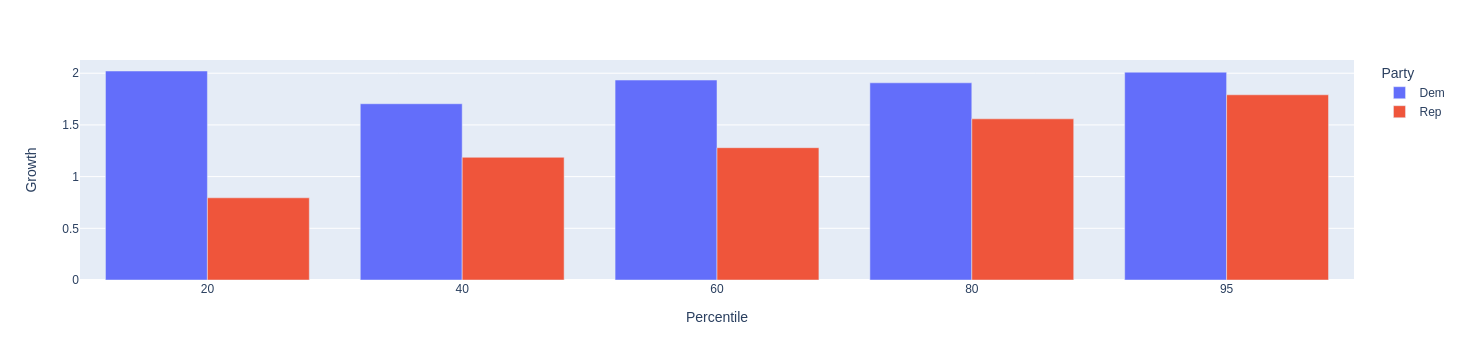

In [29]:
fig = px.bar(df_plot, x = "Percentile", y = "Growth", color = "Party", barmode = 'group')
fig.show()

In [ ]:
fig = px.bar(df_plot, x = "Percentile", y = "Growth", color = "Party", barmode = 'group')